In [20]:
#사용자 이미지
source_path = '/content/psp_result.png'

#아바타 전신(png로 변환)
target_path = '/content/target.png'

#아바타 얼굴 크롭
crop_path = '/content/crop.png'

#beautyGAN 결과
beauty_result_path = '/content/beauty_result.png'

#결과
result_path = '/content/bf_result.png'

In [21]:
from PIL import Image

img = Image.open(target_path)

# area = (x1, y1, x2, y2)
cropping_area = (1280,100,1792,612)
cropped_img = img.crop(cropping_area)
cropped_img.save(crop_path)

In [22]:
%tensorflow_version 1.x

In [23]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

In [24]:
!git clone https://github.com/kairess/BeautyGAN

Cloning into 'BeautyGAN'...
remote: Enumerating objects: 107, done.
remote: Total 107 (delta 0), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (107/107), 13.63 MiB | 28.14 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [25]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('/content/BeautyGAN/models/shape_predictor_5_face_landmarks.dat')

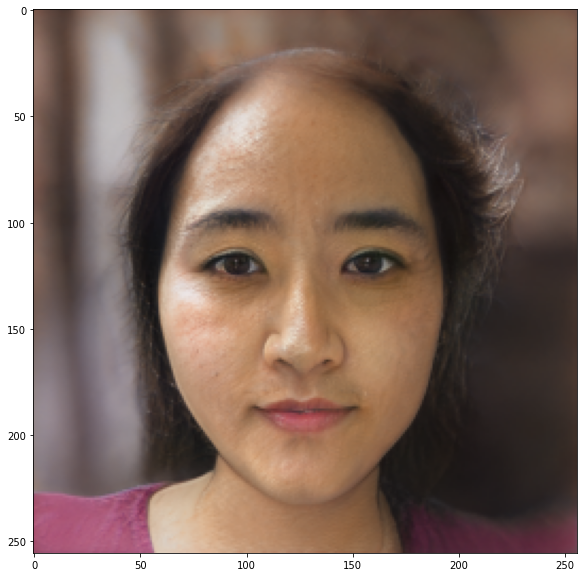

In [26]:
img = dlib.load_rgb_image(source_path)
plt.figure(figsize=(16, 10))
plt.imshow(img)

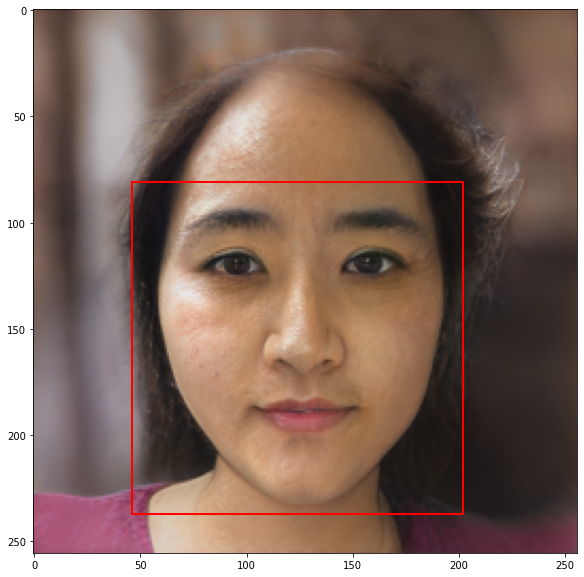

In [27]:
img_result = img.copy()

dets = detector(img, 1)

if len(dets) == 0:
    print('cannot find faces!')

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img_result)

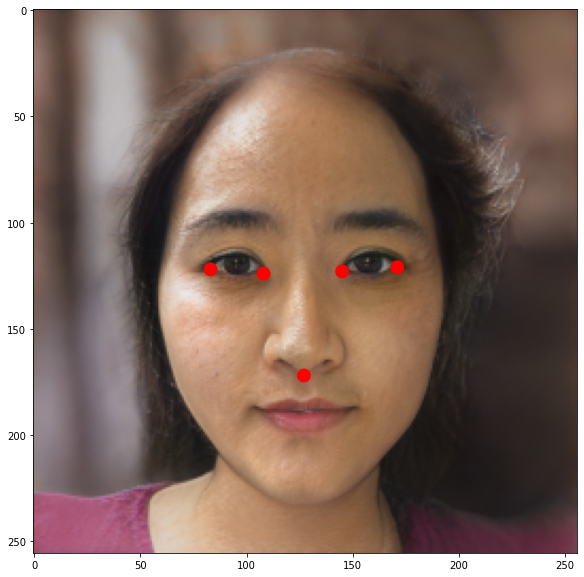

In [28]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection)
    objs.append(s)
    
    for point in s.parts():
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

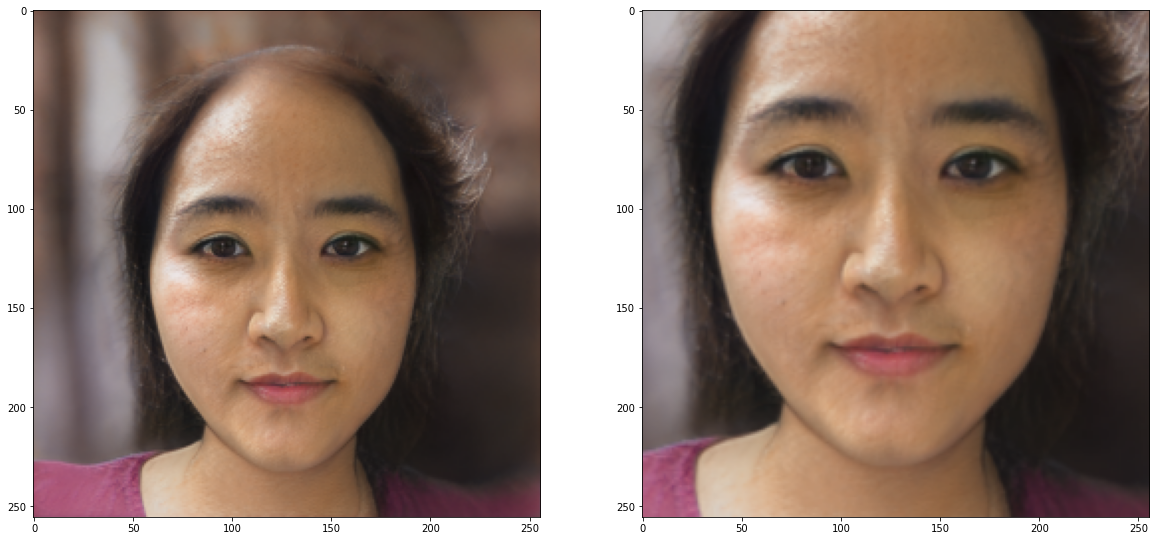

In [29]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3)

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))

axes[0].imshow(img)

for i, face in enumerate(faces):
    axes[i+1].imshow(face)

In [30]:
def align_faces(img):
    dets = detector(img, 1)
    
    objs = dlib.full_object_detections()

    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.7)
    
    return faces

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('/content/drive/MyDrive/BeautyGAN/model.meta')
saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/BeautyGAN'))
graph = tf.get_default_graph()

X = graph.get_tensor_by_name('X:0') # source
Y = graph.get_tensor_by_name('Y:0') # reference
Xs = graph.get_tensor_by_name('generator/xs:0') # output

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/BeautyGAN/model


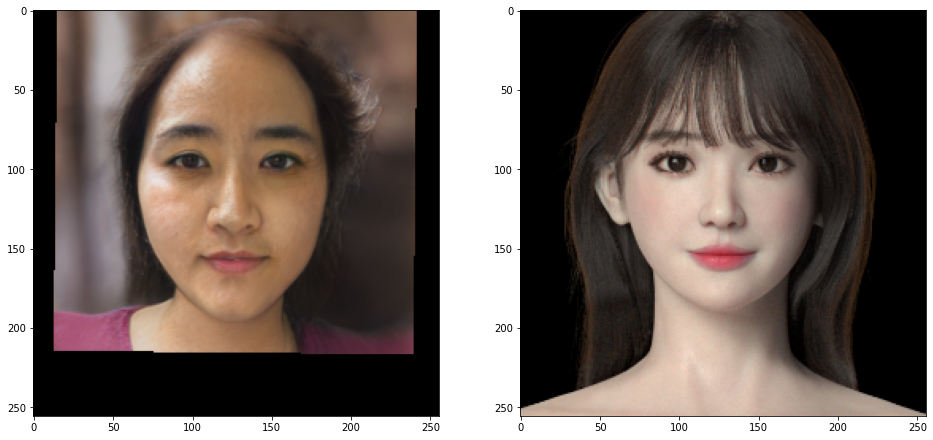

In [32]:
img1 = dlib.load_rgb_image(source_path)
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image(crop_path)
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

In [33]:
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

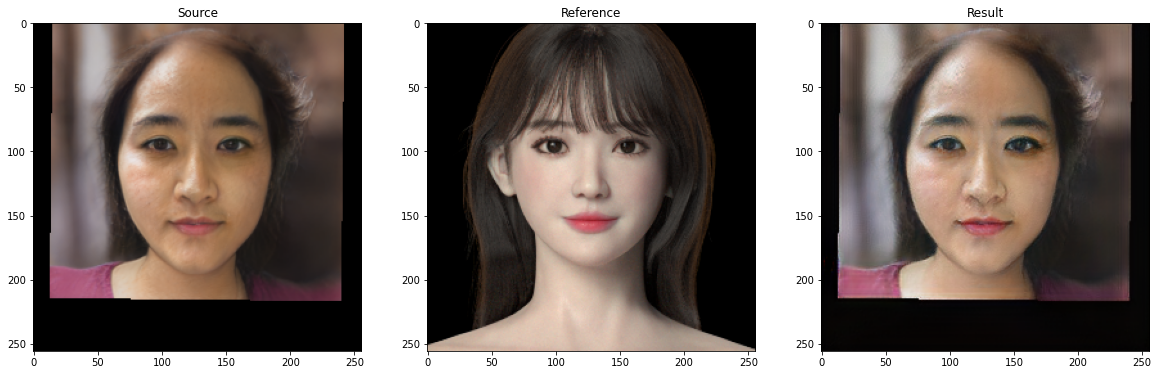

In [34]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)

In [35]:
import imageio
imageio.imwrite(beauty_result_path, output_img)

In [36]:
!git clone https://github.com/wuhuikai/FaceSwap.git

Cloning into 'FaceSwap'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 171 (delta 5), reused 1 (delta 0), pack-reused 156
Receiving objects: 100% (171/171), 96.18 MiB | 27.35 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [37]:
import os 

os.chdir('/content/FaceSwap')

command = "python main.py --src {source} --dst {target} --out {result} --correct_color --warp_2d".format(
    source = source_path, target = target_path, result = result_path)
os.system(command)

256

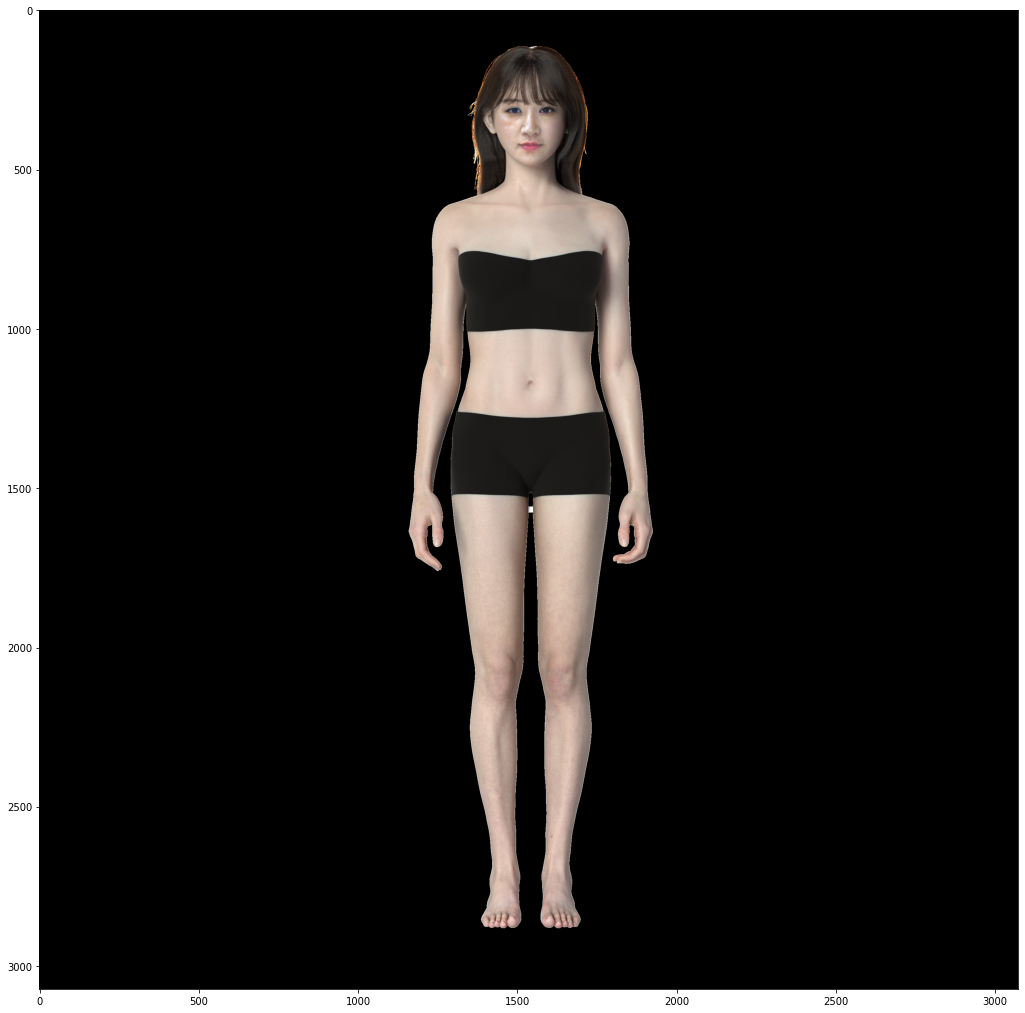

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread(result_path)

plt.figure(figsize=(18,18))
plt.imshow(image)